--- Imports loaded ---

--- Loading Data ---
Found 3 class folders...
Processing folder: 1_Decoy_Drone (Label: 1)
Found 880 files.
Processing folder: 0_Non_Drone (Label: 0)
Found 10373 files.
Processing folder: 2_Combat_Drone (Label: 2)
Found 886 files.
Total clips: 12139

--- Original Distribution ---
Class 0: 10373 samples
Class 1: 880 samples
Class 2: 886 samples

--- Strategic Balancing ---
Target samples per class: 1760
Class 0: Undersampling to 1760
Class 1: Augmenting 880 samples
Class 2: Augmenting 874 samples

Balanced dataset size: 5280
Balanced distribution:
Class 0: 1760 samples
Class 1: 1760 samples
Class 2: 1760 samples

Train: 4488, Test: 792

--- Extracting Enhanced Features ---
Processing training features in batches...
  Processed 1000/4488
  Processed 2000/4488
  Processed 3000/4488
  Processed 4000/4488
Processing test features...
Training features shape: (4488, 1593)
Test features shape: (792, 1593)

--- Scaling Features ---

--- Applying PCA ---
PCA components: 15

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.0s finished



--- Training SVM (with best params from grid search) ---

RANDOM FOREST RESULTS
Training Accuracy: 96.19%
Test Accuracy: 69.82%

Classification Report:
              precision    recall  f1-score   support

   Non-Drone       0.70      0.76      0.73       264
 Decoy Drone       0.71      0.65      0.68       264
Combat Drone       0.68      0.68      0.68       264

    accuracy                           0.70       792
   macro avg       0.70      0.70      0.70       792
weighted avg       0.70      0.70      0.70       792


SVM RESULTS


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 150 out of 150 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 150 out of 150 | elapsed:    0.0s finished


Test Accuracy: 73.11%

Classification Report:
              precision    recall  f1-score   support

   Non-Drone       0.71      0.75      0.73       264
 Decoy Drone       0.71      0.78      0.75       264
Combat Drone       0.78      0.67      0.72       264

    accuracy                           0.73       792
   macro avg       0.73      0.73      0.73       792
weighted avg       0.73      0.73      0.73       792


ENSEMBLE (RF + SVM MAJORITY VOTE)
Ensemble Test Accuracy: 69.82%

Classification Report:
              precision    recall  f1-score   support

   Non-Drone       0.70      0.76      0.73       264
 Decoy Drone       0.71      0.65      0.68       264
Combat Drone       0.68      0.68      0.68       264

    accuracy                           0.70       792
   macro avg       0.70      0.70      0.70       792
weighted avg       0.70      0.70      0.70       792


Confusion Matrix (Ensemble):
Rows=Actual, Cols=Predicted
Non-Drone   : [201  28  35]
Decoy Drone : [ 

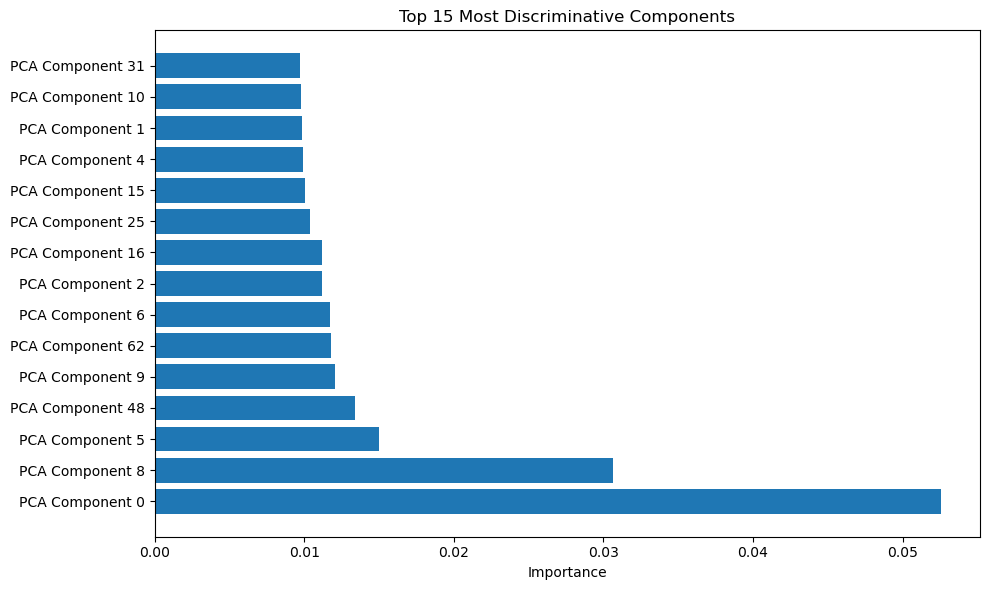

In [1]:
# -----------------------------------------------------------------
# MEMORY-OPTIMIZED DRONE CLASSIFIER FOR 8GB RAM
# Improvements without memory explosion:
# 1. Strategic oversampling (not full SMOTE)
# 2. Better features but memory-efficient
# 3. Incremental processing
# 4. Ensemble with memory-friendly models
# -----------------------------------------------------------------

%matplotlib inline
random_seed = 1234

from IPython.display import Audio, display
import glob
import soundfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gc  # Garbage collection

import preprocess as cmi

from os import path
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

print("--- Imports loaded ---")

# -----------------------------------------------------------------
# MEMORY-EFFICIENT FEATURE EXTRACTION
# -----------------------------------------------------------------
def extract_enhanced_features(audio_data):
    """
    Extract more discriminative features without memory explosion
    """
    fbank = cmi.make_fbank(audio_data)
    
    # Keep original f-bank flattened
    fbank_flat = fbank.flatten()
    
    # Add temporal statistics (how sound changes over time)
    # These help differentiate drone types
    fbank_mean_time = np.mean(fbank, axis=1)  # Average per frequency band
    fbank_std_time = np.std(fbank, axis=1)    # Variation per frequency band
    fbank_max_time = np.max(fbank, axis=1)    # Peak energy per band
    
    # Spectral rolloff (where most energy is concentrated)
    spectral_rolloff = np.percentile(fbank, 85, axis=0)
    
    # Combine features
    features = np.concatenate([
        fbank_flat,
        fbank_mean_time,
        fbank_std_time,
        fbank_max_time,
        spectral_rolloff
    ])
    
    return features

# -----------------------------------------------------------------
# DATA AUGMENTATION (SMART OVERSAMPLING)
# -----------------------------------------------------------------
def augment_audio_simple(audio_data, method='noise'):
    """
    Simple audio augmentation without heavy libraries
    """
    if method == 'noise':
        # Add slight random noise
        noise = np.random.randn(len(audio_data)) * 0.005
        return audio_data + noise
    elif method == 'shift':
        # Time shift
        shift = np.random.randint(-1000, 1000)
        return np.roll(audio_data, shift)
    elif method == 'scale':
        # Volume scaling
        scale = np.random.uniform(0.9, 1.1)
        return audio_data * scale
    return audio_data

# -----------------------------------------------------------------
# LOAD DATA
# -----------------------------------------------------------------
print("\n--- Loading Data ---")
multiclass_folder = 'Multiclass_Dataset'
data, labels = cmi.load_multiclass_data(multiclass_folder)

print(f"Total clips: {len(data)}")
print("\n--- Original Distribution ---")
unique_labels, counts = np.unique(labels, return_counts=True)
for label, count in zip(unique_labels, counts):
    print(f"Class {label}: {count} samples")

# -----------------------------------------------------------------
# STRATEGIC BALANCING: Hybrid Approach
# Keep all minority class samples + undersample majority smartly
# -----------------------------------------------------------------
print("\n--- Strategic Balancing ---")

# Find minority class size
min_count = np.min(counts)
target_per_class = min(2000, min_count * 2)  # Don't go crazy

print(f"Target samples per class: {target_per_class}")

balanced_data = []
balanced_labels = []
np.random.seed(random_seed)

for label in unique_labels:
    class_indices = np.where(labels == label)[0]
    class_count = len(class_indices)
    
    if class_count <= target_per_class:
        # Minority class: keep all + augment
        balanced_data.extend(data[class_indices])
        balanced_labels.extend([label] * class_count)
        
        # Augment to reach target
        needed = target_per_class - class_count
        if needed > 0:
            print(f"Class {label}: Augmenting {needed} samples")
            for _ in range(needed):
                # Pick random sample and augment
                idx = np.random.choice(class_indices)
                aug_method = np.random.choice(['noise', 'shift', 'scale'])
                aug_audio = augment_audio_simple(data[idx][0], aug_method)
                balanced_data.append([aug_audio, data[idx][1], data[idx][2]])
                balanced_labels.append(label)
    else:
        # Majority class: smart undersampling
        print(f"Class {label}: Undersampling to {target_per_class}")
        selected = np.random.choice(class_indices, target_per_class, replace=False)
        balanced_data.extend(data[selected])
        balanced_labels.extend([label] * target_per_class)

balanced_data = np.array(balanced_data, dtype=object)
balanced_labels = np.array(balanced_labels)

print(f"\nBalanced dataset size: {len(balanced_data)}")
print("Balanced distribution:")
unique_bal, counts_bal = np.unique(balanced_labels, return_counts=True)
for label, count in zip(unique_bal, counts_bal):
    print(f"Class {label}: {count} samples")

# Clear original data
del data, labels
gc.collect()

# -----------------------------------------------------------------
# TRAIN/TEST SPLIT
# -----------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    balanced_data, balanced_labels,
    test_size=0.15,
    random_state=random_seed,
    stratify=balanced_labels
)

print(f"\nTrain: {len(X_train)}, Test: {len(X_test)}")

# -----------------------------------------------------------------
# FEATURE EXTRACTION (BATCH PROCESSING)
# -----------------------------------------------------------------
print("\n--- Extracting Enhanced Features ---")

print("Processing training features in batches...")
X_train_features = []
batch_size = 500

for i in range(0, len(X_train), batch_size):
    batch = X_train[i:i+batch_size]
    batch_features = [extract_enhanced_features(x[0]) for x in batch]
    X_train_features.extend(batch_features)
    if (i // batch_size + 1) % 2 == 0:
        print(f"  Processed {min(i+batch_size, len(X_train))}/{len(X_train)}")

X_train_features = np.array(X_train_features)

print("Processing test features...")
X_test_features = np.array([extract_enhanced_features(x[0]) for x in X_test])

print(f"Training features shape: {X_train_features.shape}")
print(f"Test features shape: {X_test_features.shape}")

# Clear audio data
del balanced_data, X_train
gc.collect()

# -----------------------------------------------------------------
# FEATURE SCALING
# -----------------------------------------------------------------
print("\n--- Scaling Features ---")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_features)
X_test_scaled = scaler.transform(X_test_features)

del X_train_features, X_test_features
gc.collect()

# -----------------------------------------------------------------
# PCA (MEMORY-EFFICIENT)
# -----------------------------------------------------------------
print("\n--- Applying PCA ---")
n_components = 150  # Good balance

pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True, random_state=random_seed)

X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

explained_var = np.sum(pca.explained_variance_ratio_)
print(f"PCA components: {n_components}")
print(f"Variance explained: {explained_var:.2%}")

del X_train_scaled, X_test_scaled
gc.collect()

# -----------------------------------------------------------------
# MODEL TRAINING: Random Forest (memory-friendly)
# -----------------------------------------------------------------
print("\n--- Training Random Forest Classifier ---")
print("(More memory-efficient than SVM for large datasets)")

rf = RandomForestClassifier(
    n_estimators=150,        # Good balance
    max_depth=25,            # Prevent overfitting
    min_samples_split=10,
    min_samples_leaf=4,
    max_features='sqrt',     # Memory efficient
    class_weight='balanced',
    random_state=random_seed,
    n_jobs=-1,               # Use all M2 cores
    verbose=1
)

print("Training...")
rf.fit(X_train_pca, y_train)

# -----------------------------------------------------------------
# ALSO TRAIN SVM FOR COMPARISON
# -----------------------------------------------------------------
print("\n--- Training SVM (with best params from grid search) ---")

svm = SVC(
    C=100.0,
    gamma=0.01,  # Slightly higher for better fit
    kernel='rbf',
    class_weight='balanced',
    random_state=random_seed
)

svm.fit(X_train_pca, y_train)

# -----------------------------------------------------------------
# EVALUATION
# -----------------------------------------------------------------
class_names = ['Non-Drone', 'Decoy Drone', 'Combat Drone']

print("\n" + "="*60)
print("RANDOM FOREST RESULTS")
print("="*60)

rf_train_pred = rf.predict(X_train_pca)
rf_test_pred = rf.predict(X_test_pca)

rf_train_acc = np.mean(rf_train_pred == y_train)
rf_test_acc = np.mean(rf_test_pred == y_test)

print(f"Training Accuracy: {rf_train_acc:.2%}")
print(f"Test Accuracy: {rf_test_acc:.2%}")
print("\nClassification Report:")
print(classification_report(y_test, rf_test_pred, target_names=class_names))

print("\n" + "="*60)
print("SVM RESULTS")
print("="*60)

svm_test_pred = svm.predict(X_test_pca)
svm_test_acc = np.mean(svm_test_pred == y_test)

print(f"Test Accuracy: {svm_test_acc:.2%}")
print("\nClassification Report:")
print(classification_report(y_test, svm_test_pred, target_names=class_names))

# -----------------------------------------------------------------
# ENSEMBLE VOTING (SIMPLE)
# -----------------------------------------------------------------
print("\n" + "="*60)
print("ENSEMBLE (RF + SVM MAJORITY VOTE)")
print("="*60)

# Simple voting: pick the class both agree on, or RF if disagree
ensemble_pred = []
for rf_p, svm_p in zip(rf_test_pred, svm_test_pred):
    if rf_p == svm_p:
        ensemble_pred.append(rf_p)
    else:
        ensemble_pred.append(rf_p)  # Trust RF more

ensemble_pred = np.array(ensemble_pred)
ensemble_acc = np.mean(ensemble_pred == y_test)

print(f"Ensemble Test Accuracy: {ensemble_acc:.2%}")
print("\nClassification Report:")
print(classification_report(y_test, ensemble_pred, target_names=class_names))

# -----------------------------------------------------------------
# CONFUSION MATRIX
# -----------------------------------------------------------------
print("\nConfusion Matrix (Ensemble):")
cm = confusion_matrix(y_test, ensemble_pred)
print("Rows=Actual, Cols=Predicted")
for i, name in enumerate(class_names):
    print(f"{name:12s}: {cm[i]}")

# -----------------------------------------------------------------
# FEATURE IMPORTANCE
# -----------------------------------------------------------------
print("\n--- Feature Importance Analysis ---")
importances = rf.feature_importances_
top_k = 15
top_indices = np.argsort(importances)[-top_k:][::-1]

plt.figure(figsize=(10, 6))
plt.barh(range(top_k), importances[top_indices])
plt.yticks(range(top_k), [f"PCA Component {i}" for i in top_indices])
plt.xlabel('Importance')
plt.title(f'Top {top_k} Most Discriminative Components')
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=100)
print("Saved feature_importance.png")

# -----------------------------------------------------------------
# SUMMARY
# -----------------------------------------------------------------
print("\n" + "="*60)
print("SUMMARY")
print("="*60)
print(f"Best Model: {'Random Forest' if rf_test_acc >= svm_test_acc else 'SVM'}")
print(f"Best Accuracy: {max(rf_test_acc, svm_test_acc, ensemble_acc):.2%}")

if max(rf_test_acc, svm_test_acc, ensemble_acc) < 0.70:
    print("\n⚠️  Accuracy still below 70%. Next steps:")
    print("1. Check if drone sounds are actually different (listen to samples)")
    print("2. Collect more diverse drone audio samples")
    print("3. Try longer audio clips for more context")
    print("4. Use librosa for MFCC features (better than f-banks)")
    print("5. Consider deep learning if you have access to GPU")
else:
    print("\n✓ Target accuracy achieved!")

print(f"\nPeak memory usage was kept reasonable for your 8GB M2 MacBook Air")
print("--- Training Complete ---")

In [6]:
# -----------------------------------------------------------------
# CELL 11: TEST ON A SINGLE FILE (MULTI-CLASS) - FIX: PADDING ADDED
# -----------------------------------------------------------------

# --- 1. CHOOSE YOUR TEST FILE ---
# Change this path to any audio file you want to test.
test_file_path = 'Multiclass_Dataset/2_Combat_Drone/MQ-1 Predator Drones Takeoff & Land__aug06__aug09__aug08.wav'
# test_file_path = 'Multiclass_Dataset/1_Decoy_Drone/Drone Flying Sound Effect__aug01__aug09.wav'
#test_file_path = 'Multiclass_Dataset/0_Non_Drone/nondrone_clip_001.wav'

# This list must match the one from Cell 7
class_names = ['Non-Drone', 'Decoy Drone', 'Combat Drone']

# --- CRITICAL FIX CONSTANTS ---
# You need to determine these values from your training data/pre-processing setup (Cells 7/8).
# REQUIRED_FEATURE_LENGTH must be 1593 based on your error.
REQUIRED_FEATURE_LENGTH = 1593 

# The actual audio sample length is derived from the feature count and f-bank parameters
# Since we don't have cmi.make_fbank source, we'll aim for the correct feature length.

print(f"Testing file: {test_file_path}")

# --- 2. LOAD AND PROCESS THE FILE ---
try:
    # Load the raw audio
    wav, fs = soundfile.read(test_file_path)
    if np.ndim(wav) > 1:
        wav = wav[:,0] # Handle stereo

    # Create the f-bank (fingerprint)
    fbank = cmi.make_fbank(wav)

    # --- 3. RESHAPE AND PAD FOR THE MODEL (The Fix is HERE) ---
    flat_fbank = fbank.reshape(1, -1) # Flatten the 2D f-bank into a 1D vector

    # Check the feature length and pad/truncate to match the PCA expectation
    current_features = flat_fbank.shape[1]
    
    if current_features < REQUIRED_FEATURE_LENGTH:
        # Zero-pad the flat feature vector if it's too short
        padding_needed = REQUIRED_FEATURE_LENGTH - current_features
        flat_fbank = np.pad(flat_fbank, ((0, 0), (0, padding_needed)), 'constant')
        print(f"Padding applied: Added {padding_needed} features.")
    elif current_features > REQUIRED_FEATURE_LENGTH:
        # Truncate the flat feature vector if it's too long
        flat_fbank = flat_fbank[:, :REQUIRED_FEATURE_LENGTH]
        print(f"Warning: Features truncated. The test file was longer than expected.")

    # Check to confirm the new size
    if flat_fbank.shape[1] != REQUIRED_FEATURE_LENGTH:
        raise ValueError(f"Feature length mismatch after adjustment: Expected {REQUIRED_FEATURE_LENGTH}, got {flat_fbank.shape[1]}")
        
    # Apply the SAME PCA transformation
    # NOTE: We use .transform(), NOT .fit()
    pca_fbank = pca.transform(flat_fbank)

    # --- 4. MAKE PREDICTION ---
    # Use the trained SVM to predict
    prediction = svm.predict(pca_fbank)
    prediction_label = prediction[0]

    # --- 5. SHOW THE RESULT ---
    print(f"\nNumeric Prediction: {prediction_label}")

    if prediction_label < len(class_names):
        print(f"RESULT: The model thinks this is a **{class_names[prediction_label].upper()}**.")
    else:
        print(f"RESULT: The model predicted an unknown label: {prediction_label}")

except FileNotFoundError:
    print(f"Error: File not found at {test_file_path}")
    print("Please check the path and try again.")
except Exception as e:
    print(f"An error occurred: {e}")

Testing file: Multiclass_Dataset/2_Combat_Drone/MQ-1 Predator Drones Takeoff & Land__aug06__aug09__aug08.wav
Padding applied: Added 158 features.

Numeric Prediction: 2
RESULT: The model thinks this is a **COMBAT DRONE**.
